# LBM Step 2: Registration

## Registration: Correct for rigid/non-rigid movement

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

In [1]:
from pathlib import Path
import os
import sys
import numpy as np
# import zarr
import pandas as pd

import logging
import mesmerize_core as mc
from mesmerize_viz import *

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
from caiman.summary_images import correlation_pnr

# import napari

# import matplotlib.pyplot as plt

sys.path.append('../..')  # TODO: Take this out when we upload to pypi
# import lbm_caiman_python as lcp

# try:
#     import cv2
#     cv2.setNumThreads(0)
# except():
#     pass

# logging.basicConfig()

# os.environ['WAYLAND_DISPLAY'] = ''
# os.environ['RUST_LOG'] = 'info'
# os.environ['WINIT_UNIX_BACKEND'] = 'x11'

# os.environ["QT_PLATFORM_PLUGIN"] = "xcb"
# os.environ["CONDA_PREFIX_1"] = ""

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

In [7]:
from mesmerize_core import *
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from copy import deepcopy
import pandas as pd

## Logging

In [2]:
# set up logging
debug = True

logger = logging.getLogger("caiman")
logger.setLevel(logging.WARNING)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

# set env variables
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

if debug:
   logging.getLogger("caiman").setLevel(logging.DEBUG)

## (optional): View hardware information

In [3]:
# !pip install cloudmesh-cmd5
!cms help # dont forget to call it after the install as it sets some defaults
!cms sysinfo

*** No help on # dont forget to call it after the install as it sets some defaults
+------------------+----------------------------------------------------------------------------------------------+
| Attribute        | Value                                                                                        |
+------------------+----------------------------------------------------------------------------------------------+
| cpu              |                                                                                              |
| cpu_cores        | 24                                                                                           |
| cpu_count        | 32                                                                                           |
| cpu_threads      | 32                                                                                           |
| date             | 2024-09-26 12:48:53.444986                                                          

## User input: input data path and plane number

the same path as [pre_processing](./pre_processing.ipynb)
parent_dir = Path().home() / 'caiman_data' / 'animal_01' / 'session_01'

In [8]:
# File locations:
# - batch.pickle parent directory
# - input movie

# parent_path = Path().home() / "caiman_data_org"
parent_path = Path().home() / "caiman_data" / 'animal_01' / 'session_01'
save_path = parent_path / 'motion_correction'

# for TIFF
# tiff_path = parent_path / 'tiff'
# tiff_files = [x for x in Path(tiff_path).glob('*.tif*')]

# for ZARR
movie_path = parent_path 
movie = zarr.open(movie_path)['mov']

reg_batch_path = parent_path / 'batch.pickle'
df = mc.load_batch(reg_batch_path)
# df = lcp.lbm_load_batch(reg_batch_path, overwrite=False)

df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,session_01,mov,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...","{'success': False, 'traceback': 'Traceback (most recent call last): File ""c:\Users\RBO\miniconda3\envs\mbo-caiman\...",2024-09-25T20:23:56,2024-09-25T20:24:05,0.16 sec,None,995691a6-26b8-410d-b6bb-010c4e3c8281
1,mcorr,extracted_plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328_mean_projection.n...,2024-09-26T11:56:54,2024-09-26T12:02:55,77.3 sec,None,b32f41bf-a9a5-4965-be7c-e6779e854328


In [6]:
sorted(tiff_files)

[WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_1.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_10.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_11.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_12.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_13.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_14.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_15.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_16.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_17.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_18.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/animal_01/session_01/tiff/extracted_plane_19.tif'),


# Default registration parameters

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

In [6]:
pix_res = 1

mx = 10/pix_res
max_shifts = (int(mx), int(mx))       # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True        # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'var_name_hdf5': 'mov',
        'max_shifts': max_shifts,
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': None
    },
}

# # Add a "batch item" to the DataFrame this is the combination of:
# * algorithm to run, `algo`
# * input movie to run the algorithm on, `input_movie_path`
# * parameters for the specified algorithm, `params`
# * a name for you to keep track of things, usually the same as the movie filename, `item_name`
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=movie_path / 'mov',
    params=mcorr_params,
    item_name=movie_path.stem,  # filename of the movie, but can be anything
)

In [8]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,session_01,mov,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...","{'success': False, 'traceback': 'Traceback (most recent call last): File ""c:\Users\RBO\miniconda3\envs\mbo-caiman\...",2024-09-25T20:23:56,2024-09-25T20:24:05,0.16 sec,None,995691a6-26b8-410d-b6bb-010c4e3c8281
1,mcorr,extracted_plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328_mean_projection.n...,2024-09-26T11:56:54,2024-09-26T12:02:55,77.3 sec,None,b32f41bf-a9a5-4965-be7c-e6779e854328


# First registration run: preset with good defaults

Technical notes: On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.

In [9]:
df.iloc[1].caiman.run()

Running b32f41bf-a9a5-4965-be7c-e6779e854328 with local backend
starting mc


      838959 [cluster.py:setup_cluster():225] [10504] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape


mc finished successfully!
computing projections
Computing correlation image


      916256 [cluster.py:stop_server():177] [10504] stop_cluster(): done


finished computing correlation image


INFO:caiman.cluster:stop_cluster(): done


## Preview Motion Correction

Before running a grid search for the best parameter set, preview your registration results

In [3]:
viz = df.mcorr.viz(data_options=["input", "mcorr", "mean", "corr"], start_index=1)
viz.show()

c:\Users\RBO\anaconda3\envs\mescore\lib\site-packages\ipydatagrid\datagrid.py:512: UserWarning: Index name of 'index' is not round-trippable.
  schema = pd.io.json.build_table_schema(dataframe)
<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape


RFBOutputContext()

c:\Users\RBO\anaconda3\envs\mescore\lib\site-packages\fastplotlib\graphics\_features\_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


c:\Users\RBO\anaconda3\envs\mescore\lib\site-packages\fastplotlib\widgets\image.py:78: UserWarning: Invalid 'window size' value for function: <function mean at 0x0000014720A30280>, setting 'window size' = None for this function. Valid values are integers >= 3.
  warn(


In [ ]:
viewer = napari.Viewer()
viewer.add_image(mcorr_movie, name=f'plane_2_a')
viewer.add_image(mcorr_movie2, name=f'plane_2_b')

# Registration Grid Search (if you need it!)

More runs with varying parameters, stored on disk in the dataframe batch.pickle

In [37]:
# copy the mcorr_params2 dict to make some changes
# some variants of max_shifts
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=tiff_files[0],
            params=new_params,
            item_name=tiff_files[0].stem,  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",{'mean-projection-path': 'e7d6ee76-b236-4fdc-a978-da72abb5b6cd/e7d6ee76-b236-4fdc-a978-da72abb5b6cd_mean_projection....,2024-09-12T17:38:56,2024-09-13T00:40:44,41.1 sec,None,e7d6ee76-b236-4fdc-a978-da72abb5b6cd
1,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_deviation_rigi...",None,2024-09-13T00:53:41,None,None,None,1ea42667-276d-486f-a63e-0cbbf0744ca8
2,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (2, 2), 'strides': (64, 64), 'overlaps': (32, 32), 'max_deviation_ri...",None,2024-09-13T00:53:41,None,None,None,9aa2b5f3-14f0-4fbb-bfed-907c50969918
3,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (32, 32), 'strides': (12, 12), 'overlaps': (6, 6), 'max_deviation_ri...",None,2024-09-13T00:53:41,None,None,None,703926de-8926-4613-a9e6-abe5c0cbedeb
4,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max_deviation_...",None,2024-09-13T00:53:41,None,None,None,c0685366-5d8c-4dec-b607-44265f5033cc


In [38]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

/home/mbo/caiman_data_org/animal_01/session_01/1ea42667-276d-486f-a63e-0cbbf0744ca8.runfile
starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/animal_01/session_01/9aa2b5f3-14f0-4fbb-bfed-907c50969918.runfile


2024-09-13 00:53:48.814012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:53:48.814044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:53:48.814390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:53:48.817005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/animal_01/session_01/703926de-8926-4613-a9e6-abe5c0cbedeb.runfile


2024-09-13 00:55:32.175065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:55:32.175096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:55:32.175457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:55:32.178227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/animal_01/session_01/c0685366-5d8c-4dec-b607-44265f5033cc.runfile


2024-09-13 00:56:14.293577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:56:14.293616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:56:14.294074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:56:14.297998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image



2024-09-13 00:58:00.267324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:58:00.267357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:58:00.267712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:58:00.270576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t


# Distinguishing parameter variants

We can see that there are many parameter variants, but it is not easy to see the differences in parameters between the rows that have the same `item_name`.

We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`

In [7]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

,overlaps,max_shifts,strides
0,"[24, 24]","(10, 10)","[48, 48]"
1,"(6, 6)","(2, 2)","(12, 12)"
2,"(32, 32)","(2, 2)","(64, 64)"
3,"(6, 6)","(32, 32)","(12, 12)"
4,"(32, 32)","(32, 32)","(64, 64)"


# Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [11]:
plane = 1

df = df.caiman.reload_from_disk()

# first item is just the raw movie

movies = [df.iloc[0].caiman.get_input_movie()]

subplot_names = ["raw"]

means = [df.iloc[0].caiman.get_projection("mean")]

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():

    if row.algo != 'mcorr':
        continue

    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]

    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")

    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))

ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape


In [15]:
iw_zfish = fpl.ImageWidget(
    data=[movies[0], movies[1]],
    names=['Raw', 'Corrected'],
    cmap="gray",
    histogram_widget=False
)
iw_zfish.show()

RFBOutputContext()

/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  | attribute  | type        | description                                   |


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

ERROR:wgpu:Draw error: Validation Error (7)
ERROR:wgpu:Present error: present() is called without a preceeding call to get_c… (7)
ERROR:wgpu:Draw error: Validation Error (8)
ERROR:wgpu:Present error: present() is called without a preceeding call to get_c… (8)
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  | attribute  | type        | description                                   |


In [23]:
napari.view_image(movies[0], name=subplot_names[0])


# mcorr_movie = df.iloc[0].mcorr.get_output()
# mcorr_movie2 = df.iloc[-1].mcorr.get_output()
# corr, pnr = correlation_pnr(mcorr_movie, swap_dim=False)
# corr2, pnr2 = correlation_pnr(mcorr_movie2, swap_dim=False)

Viewer(camera=Camera(center=(0.0, 299.5, 279.5), zoom=1.3079464285714284, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(864.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=1729.0, step=1.0), RangeTuple(start=0.0, stop=599.0, step=1.0), RangeTuple(start=0.0, stop=559.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(864.0, 299.0, 279.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'raw' at 0x7f202c877f50>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f22ca409d

In [47]:
import napari
viewer = napari.Viewer()
viewer.add_image(mcorr_movie, name=f'plane_2_a')
viewer.add_image(mcorr_movie2, name=f'plane_2_b')
viewer.add_image(corr, name="Mean Correlation")
viewer.add_image(corr2, name="Mean Correlation2")

<Image layer 'Mean Correlation2' at 0x7fe77fe5cad0>

In [ ]:
napari.view_image(df.iloc[0].mcorr.get_output()[::2, ...])
napari.current_viewer().add_image(df.iloc[0].caiman.get_input_movie()[::2, ...])

ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape


<Image layer 'pnr' at 0x7f4cd3c0cc10>

## Correlation metrics

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [5]:
row_index = i

mean_proj = df.iloc[i].caiman.get_projection("mean")
max_proj = df.iloc[i].caiman.get_projection("max")
std_proj = df.iloc[i].caiman.get_projection("std")
corr_image = df.iloc[i].caiman.get_corr_image()
# viewer.add_image(mcorr_movie, rgb=False, multiscale=False)
# viewer.add_image(input_movie['plane_1'], rgb=False, multiscale=False)

viewer = napari.Viewer()
viewer.add_image(mean_proj)
viewer.add_image(std_proj)
viewer.add_image(max_proj)
viewer.add_image(corr_image)

NameError: name 'i' is not defined

## Pixel Shifts

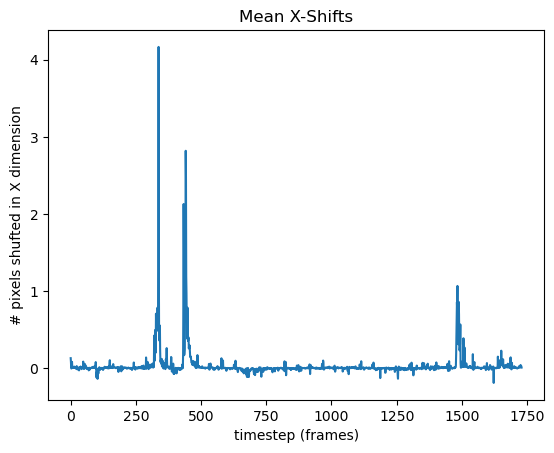

In [6]:
row_idx = 0

shifts = df.iloc[row_idx].mcorr.get_shifts()
shifts = shifts[1]
shiftsx = [x[0] for x in shifts]
shiftsy = [x[1] for x in shifts]
shiftsx_mean = [np.mean(x) for x in shiftsx]
shiftsy_mean = [np.mean(y) for y in shiftsy]
##%%
xr = list(range(1730))
plt.plot(xr, shiftsx_mean)
plt.title('Mean X-Shifts') # TODO: std error bars, napari layer
plt.xlabel("timestep (frames)")
plt.ylabel("# pixels shufted in X dimension")
plt.show()

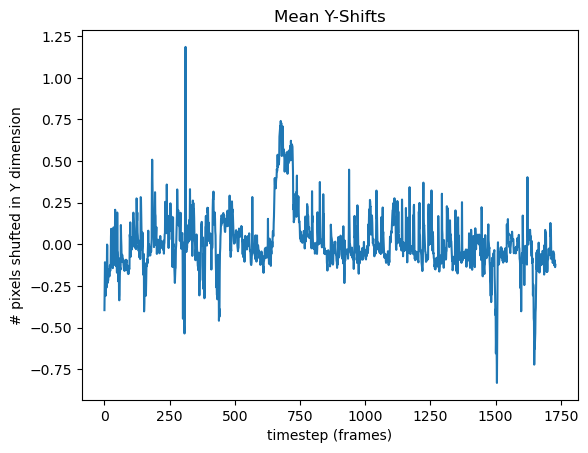

In [7]:
xr = list(range(1730))

plt.title('Mean Y-Shifts') # TODO: std error bars, napari layer
plt.xlabel("timestep (frames)")
plt.ylabel("# pixels shufted in Y dimension")
plt.plot(xr, shiftsy_mean)

# Optional, cleanup DataFrame

Use the index that works best and all other items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

**Note:** On windows calling `remove_item()` will raise a `PermissionError` if you have the memmap file open. The workaround is to shutdown the current kernel and then use `df.caiman.remove_item()`. For example, you can keep another notebook that you use just for cleaning unwanted mcorr items.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

Indices are always reset when you use `caiman.remove_item()`. UUIDs are always preserved.

In [14]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2/5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2_mean_projection....,2024-09-09T14:50:33,2024-09-10T09:55:53,42.42 sec,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 'aab79e23-ebcc-45cb-a12b-6f7e3eae935c/aab79e23-ebcc-45cb-a12b-6f7e3eae935c_mean_projection....,2024-09-09T14:50:49,2024-09-10T09:57:13,42.87 sec,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c
2,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
3,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T10:46:06,None,None,None,00dc740c-7cf4-4cbb-b239-4cd8fc0439a2
4,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T11:05:25,None,None,None,0b04ece1-0bf1-4d76-8688-f4091e06ca2b


In [15]:
rows_keep = [2]
for i, row in df.iterrows():
    if i not in rows_keep:
        df.caiman.remove_item(row.uuid, safe_removal=False)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02


In [16]:
df.caiman.save_to_disk()

Name,/mov
Type,zarr.core.Array
Data type,float64
Shape,"(1730, 584, 544)"
Chunk shape,"(52, 584, 544)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4396912640 (4.1G)
No. bytes stored,1118784685 (1.0G)


## Evaluate Results: Optical Flow

In [20]:
import caiman as cm

In [9]:
# fnames = [df.iloc[0].mcorr.get_]
# fnames = [str(df.iloc[0].mcorr.get_output_path())]
fnames = str(movie_path)
fnames_rig = str(df.iloc[0].mcorr.get_output_path())

#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(movie[1,:,:].shape, 2 * 2) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

NameError: name 'movie' is not defined

In [27]:
%%capture

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)


In [30]:
tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    fnames_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

# tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
#     mc.fname_tot_els[0], final_size[0], final_size[1],
#     swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [62]:
fpath = cm.paths.fname_derived_presuffix(str(fnames), 'metrics', swapsuffix='npz')
fpath

'/home/mbo/caiman_data_org/animal_01/session_01/plane_1_metrics.npz'

In [8]:
##%% plot the results of Residual Optical Flow
fls = [cm.paths.fname_derived_presuffix(str(fnames), 'metrics', swapsuffix='npz'), cm.paths.fname_derived_presuffix(str(fnames_rig), 'metrics', swapsuffix='npz')]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['raw','corrected',]):
    print('fl')
    if Path(fl).suffix == '.npz':
        with np.load(str(fl)) as ld:
            print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
                ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
            plt.subplot(len(fls), 3, 1 + 3 * cnt)
            plt.ylabel(metr)
            try:
                mean_img = np.mean(cm.load(fl[:-12] + '.tif'))[12:-12, 12:-12]
            except:
                try:
                    mean_img = np.mean(
                        cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
                except:
                    try:
                        mean_img = np.mean(
                            cm.load(fl[:-12] + '.hdf5'), 0)[12:-12, 12:-12]
                    except:
                        try:
                            mean_img = np.mean(cm.load(fl[:-12] + '.zarr'), 0)[12:-12, 12:-12]
                        except:
                            print(fl[:-12] + '.zarr')



            lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
            plt.imshow(mean_img, vmin=lq, vmax=hq)
            plt.title('Mean Optical Flow')
            plt.subplot(len(fls), 3, 3 * cnt + 2)
            plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
            plt.title('Corr image')
            plt.subplot(len(fls), 3, 3 * cnt + 3)
            flows = ld['flows']
            plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
            plt.colorbar()


            lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
            plt.imshow(mean_img, vmin=lq, vmax=hq)
            plt.title('Mean Optical Flow')
            plt.subplot(len(fls), 3, 3 * cnt + 2)
            plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
            plt.title('Corr image')
            plt.subplot(len(fls), 3, 3 * cnt + 3)
            flows = ld['flows']
            plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
            plt.colorbar()

NameError: name 'cm' is not defined

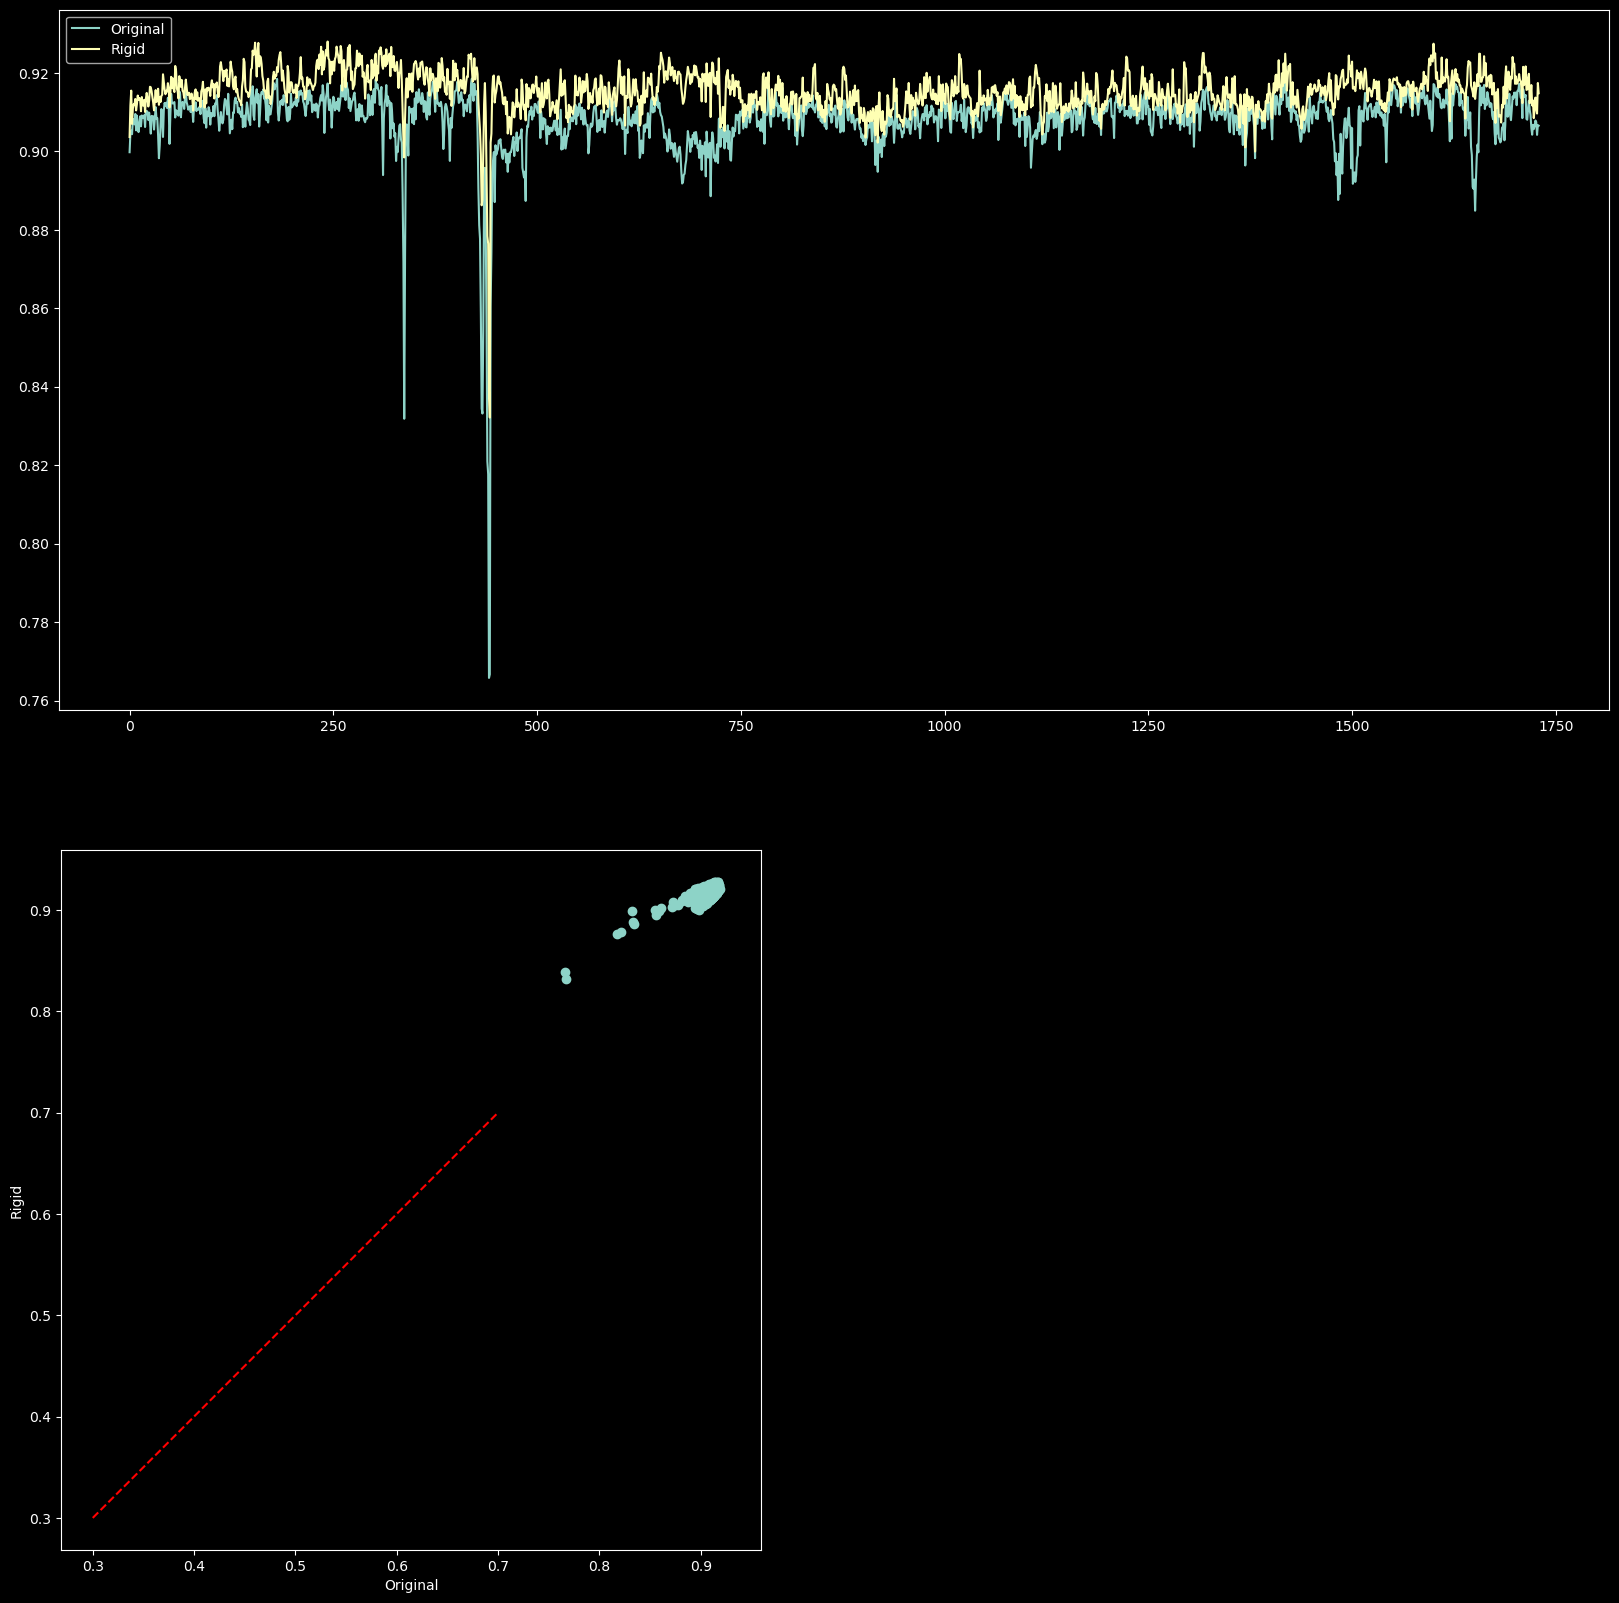

In [71]:
plt.figure(figsize = (20,20))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig);
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original');
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');